# Embedding

##

### 2022-1 RecommenderSystem Project

#### Enviroment
- python ->	3.9.7
- pandas ->	1.4.1
- numpy ->	1.21.5
- nltk ->	3.7

#### Data
- beer_reviews.csv (https://www.kaggle.com/datasets/rdoume/beerreviews)

#### Author
- Lee Junhee

---

#### 데이터 살피기

필요한 패키지를 추가한다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 자연어 처리 라이브러리 토큰화를 위해 사용
import nltk
# nltk.tokenize.word_tokenize 함수를 사용하기 위해 주석을 해제하여 실행해야한다.
# nltk.download('punkt')

# 불용어를 위해 쓰이는 라이브러리
import requests
import re

CSV 파일에서 데이터를 읽어 온다.

In [2]:
dataTypeDict = {}
beers = pd.read_csv("./data/merged_data.csv")

상위의 데이터를 살펴본다.

In [3]:
beers.head()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,Description
0,10,163,Amstel Brouwerij B. V.,1010963392,3.0,2.0,3.0,fodeeoz,Light Lager,2.5,2.5,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
1,18,163,Amstel Brouwerij B. V.,1010861086,2.5,3.0,3.0,jdhilt,Light Lager,2.0,2.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
2,30,163,Amstel Brouwerij B. V.,1002109880,3.0,2.0,2.0,xXTequila,Light Lager,2.0,3.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
3,40,163,Amstel Brouwerij B. V.,988202869,3.0,3.0,3.0,Brent,Light Lager,2.0,2.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
4,750,163,Amstel Brouwerij B. V.,1264904623,3.5,2.5,3.5,brownbeer,Light Lager,3.0,3.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t


하위의 데이터를 살펴본다.

In [4]:
beers.tail()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,Description
452949,1683163,14359,The Defiant Brewing Company,1175746381,3.5,4.0,4.0,maddogruss,American IPA,4.0,4.0,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...
452950,1683164,14359,The Defiant Brewing Company,1171081089,4.0,4.5,4.0,dherling,American IPA,4.0,4.5,India Pale Ale,6.2,35185,Green Man India Pale Ale is delectably hoppy w...
452951,1683165,14359,The Defiant Brewing Company,1171081089,4.0,4.5,4.0,dherling,American IPA,4.0,4.5,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...
452952,1683166,14359,The Defiant Brewing Company,1170979828,4.0,4.0,4.5,cbl2,American IPA,4.0,4.0,India Pale Ale,6.2,35185,Green Man India Pale Ale is delectably hoppy w...
452953,1683167,14359,The Defiant Brewing Company,1170979828,4.0,4.0,4.5,cbl2,American IPA,4.0,4.0,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...


#### Embedding 과정

각 맥주들을 표현한 의미있는 Embedding을 위해 Description 값을 이용한다. Description은 맥주의 설명을 적은 문장이므로, 각 문장을 Vector화 한다면 맥주를 표현하는 Embedding vector라 볼 수 있다.

Description을 사용하기 전에 임의 데이터의 Description 값을 출력해본다.

In [5]:
print(f"beer_name: { beers['beer_name'].iloc[0] } \ndescription: {beers['Description'].iloc[0]}\n")
print(f"beer_name: { beers['beer_name'].iloc[452952] } \ndescription: {beers['Description'].iloc[452952]}\n")

beer_name: Amstel Light 
description: ABV in the USA is 4.1%	

beer_name: India Pale Ale 
description: Green Man India Pale Ale is delectably hoppy with a properly balanced body. Generous hop additions give it a wonderful bitterness and pleasant floral nose, while our combination of traditional British malts creates a rich, satisfying flavor and alluring copper color. This authentic English-style IPA is our flagship ale.	



두개의 데이터 중 상위의 데이터(Amstel Light)의 경우는 Description에서 맥주의 특징을 잘 설명하지 않고 있다. 아래의 데이터(India Pale Ale)는 Description에 맥주에 대한 설명히 자세하게 적혀있다.

위의 데이터의 경우, Embedding vector를 얻는 것이 힘들어 보이고 아래 데이터의 경우, 적절한 임베딩 벡터를 얻을 수 있을거라 예상한다.

임베딩을 위해서 각 문장을 수치화 해야한다. 문장을 수치화 하기 위한 방법으로 **Bag of Words 모델**을 사용하여 단어의 빈도수에 대한 집합으로 나타낸다. nltk 패키지를 사용하였다.

위의 과정을 위해 일단 Description을 따로 DataFrame으로 뽑아낸다.

In [6]:
descriptions = beers["Description"]
descriptions

0                                  ABV in the USA is 4.1%\t
1                                  ABV in the USA is 4.1%\t
2                                  ABV in the USA is 4.1%\t
3                                  ABV in the USA is 4.1%\t
4                                  ABV in the USA is 4.1%\t
                                ...                        
452949    This ale is traditionally highly hopped and ro...
452950    Green Man India Pale Ale is delectably hoppy w...
452951    This ale is traditionally highly hopped and ro...
452952    Green Man India Pale Ale is delectably hoppy w...
452953    This ale is traditionally highly hopped and ro...
Name: Description, Length: 452954, dtype: object

Descriptions는 맥주에 대한 사용자들의 평가 데이터에서 가져온 데이터 이기 때문에 중복이 되어 나타난다.

맥주에 대한 Description을 Dataframe로 만든다.

In [7]:
beer_descriptions = pd.DataFrame(descriptions.unique(), columns=["beer_descriptions"])
print(beer_descriptions)

                                      beer_descriptions
0                              ABV in the USA is 4.1%\t
1     'Oak Aged Imperial Porter Brewed with Chocolat...
2                              Formerly In-Heat Wheat\t
3     An authentic example of a Bavarian Hefeweizen....
4     Our Hefeweizen is a light, unfiltered wheat be...
...                                                 ...
1398  Foster is our Black Wheat IPA, brewed with a l...
1399  Batch 2: Barrel aged for 18 months in hand sel...
1400  Ephraim (1823-1913) was our great-great grandf...
1401  James was our Uncle (Edward James Hill Jr.). H...
1402  Fear and Trembling is Hill Farmstead’s first c...

[1403 rows x 1 columns]


각 Description을 단어로 토큰화 한다.

In [8]:
tokenized_descriptions = beer_descriptions["beer_descriptions"].apply(nltk.tokenize.word_tokenize).to_numpy()
# 3개만 출력
print(tokenized_descriptions[:3])

[list(['ABV', 'in', 'the', 'USA', 'is', '4.1', '%'])
 list(["'Oak", 'Aged', 'Imperial', 'Porter', 'Brewed', 'with', "Chocolate'Caldera", 'Kettle', 'SeriesJune', '2011', '-', 'first', 'release', 'in', 'waxed', '22', 'oz', '.', 'bottles'])
 list(['Formerly', 'In-Heat', 'Wheat'])]


토큰화된 단어들을 하나의 리스트로 만든다. 그리고 중복된 단어들을 지운 단어의 집합을 만든다. 모든 단어들은 소문자화 한다.

In [9]:
all_words = np.concatenate(tokenized_descriptions)
lower_case = lambda word: str.lower(word)
all_words = [lower_case(word) for word in all_words]
words = set(all_words)
print(f"Number of words: {len(all_words)}")
print(f"Number of unique words: {len(words)}")


Number of words: 87896
Number of unique words: 9674


고유한 한 가지 단어가 나온 빈도수를 값으로 갖는 DataFrame를 만든다.

In [10]:
word_counts = dict.fromkeys(words, 0)
for word in all_words:
	word_counts[word] += 1

word_counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=["counts"])
word_counts.head(10)

,counts
fruitinessflavor,1
144carbohydrates,1
independent™,1
ark,1
spend,3
simple,3
bucks,1
two-year,2
ask,2
germanic,1


영어 불용어를 삭제한다. 불용어는 이미 만들어진 것을 가져와 사용했다.

In [11]:
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

for index in word_counts.index:
	if index in stopwords:
		word_counts = word_counts.drop(index)

word_counts

,counts
fruitinessflavor,1
144carbohydrates,1
independent™,1
ark,1
spend,3
...,...
royal,2
edward,2
maturity,1
lord,2


숫자와 문장부호도 보인다. regular expression을 이용하여 삭제하자.

In [47]:
r = re.compile("[0-9]+|\W+")

for index in word_counts.index:
	if r.match(index) != None :
		word_counts = word_counts.drop(index)

word_counts

,counts
fruitinessflavor,1
independent™,1
ark,1
spend,3
simple,3
...,...
royal,2
edward,2
maturity,1
lord,2


기술 통계량을 살펴보자.

In [48]:
word_counts.describe()

,counts
count,8500.000000
mean,4.975647
std,22.249476
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1041.000000


단어 갯수 8500개중 어림잡아 50% 이상 단어의 빈도수가 1임을 알 수 있다. 그리고 가장 큰 빈도수는 1041이다.

한 번 나온 단어는 맥주들을 표현하는 단어라고 보기에 적합하지 않다. 전체 맥주에서 맥주를 표현한 단어라면 한 번 나오지는 않았을 것이다. 그러므로 **1은 무의미하니 없앤다.**

In [49]:
word_counts = word_counts.drop(word_counts[word_counts.counts == 1].index)
word_counts.describe()

,counts
count,3516.000000
mean,10.611206
std,33.805129
min,2.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,1041.000000


3516개의 단어가 선정 되었다. histogram으로 분포도를 확인해보자.

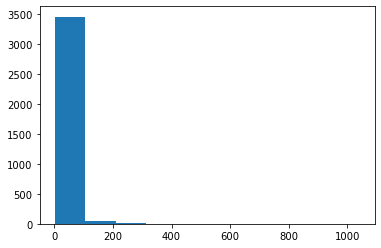

In [50]:
plt.hist(word_counts, bins=10)
plt.show()


TODO: 데이터 노이즈 더 처리 => 맥주에 대한 사전 완성 => 사전 인덱스로 multi-hot indexing  == 맥주 표현 벡터 => 차원 축소(Autoencoder, CF) => beer 임베딩 

최대값 4369나 높은 빈도수를 갖는 단어는 맥주를 표현하는 단어로써 무의미하다. (is, a 같은 것들) **임계치를 정해 지워주자.**

In [ ]:
threshold = 10
word_counts = word_counts.drop(word_counts[word_counts.counts > threshold].index)
print(word_counts)

In [147]:
MIN_THRESHOLD = 7

word_counts = word_counts.drop(word_counts[word_counts.counts < 7].index)
word_counts

,counts
native,8
White,9
Revolution,7
worthy,7
massive,8
...,...
rise,7
results,9
apricot,9
Vol,10


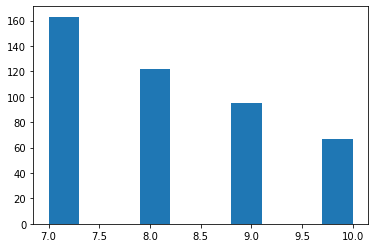

In [148]:
plt.hist(word_counts, bins=10)
plt.show()